#### User Selections

In [35]:
chroms = [1]#,'X']
region_idxs = list(range(0,1000,50))
sample_dir = '../../data/samples/small_model_large_embedder/'#small_model/'#'../diffusion_v1/sampling_small/'
milestone = 84
cond_scales = [1,2,4,6,8]#[1.]#[float(k) for k in range(1,6)]
rescaled_phis = [0,.25,.5,.75,1]#[k/10 for k in range(1,11)]
has_symmetry = True 
nbeads=65

#### Imports

In [2]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap

#### Support Functions

In [20]:
def load_sample(
    directory,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom
):
    if directory != '' and directory[-1] != '/':
        directory+= '/'
        
    fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
    
    return Sample(data=pd.read_pickle(fp).batch)

class ComputeSubregion: # This will select the relevant subregions!

    def __init__(self,nbeads,includes_self_interaction):

        self.return_size = nbeads // 2
        shift = int(includes_self_interaction)
        self.includes_self_interaction = includes_self_interaction
        self.start_size = nbeads - 1 + shift
        self.index_for_large_matrix = (
            torch.arange(self.return_size).repeat_interleave(self.return_size), # 0,0,0,...,1,1,1,...,N,N,N
            torch.cat([torch.arange(i,i+self.return_size) for i in range(shift,self.return_size+shift)]) # 1,2,3,...,N+1,2,3,..,N+2,...,N+small_size (if shift=1)
        )
    def __call__(self,full_maps):
        n,i,j = self.return_size, *self.index_for_large_matrix
        return full_maps[...,i,j].unflatten(-1,(n,n))

    def inverse(self,submap):
        N,i,j,optional_dims = self.start_size,*self.index_for_large_matrix,submap.shape[:-2]
        full_shape = (*optional_dims,N,N) 
        full_maps = torch.empty(
            full_shape,
            device=submap.device,
            dtype=submap.dtype
        ).fill_(torch.nan)
        
        full_maps[...,i,j] = full_maps[...,j,i] = submap.flatten(-2) 
        if self.includes_self_interaction: 
            i = torch.arange(N) 
            full_maps[...,i,i] = 0 
        return full_maps

compute_subregion = ComputeSubregion(nbeads,False)#True)

def load_sample(
    directory,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom,
    has_symmetry=has_symmetry
):
    if directory != '' and directory[-1] != '/':
        directory+= '/'
        
    fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
    data = pd.read_pickle(fp).batch
    if not has_symmetry: 
        print(data.shape)
        print(compute_subregion.inverse(data).shape)
        sample = Sample(data=compute_subregion.inverse(data))
        sample.normalized = True
    else: 
        sample = Sample(data=data)

    return sample

In [4]:
def get_exp_map(region_idx,exp_hic,emb_idx,interp_nans=True): 

    # Get the region information from the embedding index used during sample generation
    region_length, chrom, start = emb_idx[region_idx]
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [5]:
def get_best_rc_sigma(
    gen_sample,
    exp_probs,
    r_cs = torch.arange(1.5,2.5,.05).tolist(),
    sigmas = torch.arange(2,6,.25).tolist()
):
    
    best_pcc = -2
    best_r_c = 0 
    best_sigma = 0 
    best_map = None
    for r_c in r_cs: 
        for sigma in sigmas: 
            gen_probs = gen_sample.contact_probabilities(r_c=r_c,sigma=sigma)
            pcc = gen_probs.pcc(exp_probs) 
            if pcc > best_pcc: 
                best_map = gen_probs
                best_r_c = r_c 
                best_sigma = sigma
                best_pcc = pcc
    
    return best_map,r_c,sigma,best_pcc

In [6]:
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
def pipeline(
    chrom,
    region_idx,
    sample_dir,
    milestone,
    cond_scales,
    rescaled_phis,
    exp_hic=None,
    embedding_idx=None
):

    ########################
    # Prepare for computations
    print("Preparation",flush=True)
    
    # Use the GPU if its available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load the relevant data 
    if exp_hic is None:
        exp_hic = HiCDataset() # Interface for cooler object
    if embedding_idx is None:
        embedding_idx = pd.read_pickle(emb_fp(chrom)).index # Embeddings for the selected chromosome 
    
    # Initialize the object to hold all the data
    corrcoefs = torch.empty(len(cond_scales),len(rescaled_phis),dtype=torch.double,device=device)
    r_cs = torch.empty(len(cond_scales),len(rescaled_phis))
    sigmas = torch.empty(len(cond_scales),len(rescaled_phis))

    # Get the experimental probability map, which is used repeatedly in the loop 
    exp_probs = get_exp_map(region_idx,exp_hic,embedding_idx).to(device)
    
    ########################
    # Core Computations, etc. 
    if os.path.exists(sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt'):
        temp = torch.load(sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt')
        corrcoefs = temp['corrcoefs']
        r_cs = temp['r_cs'] 
        sigmas = temp['r_cs']
        cond_scales = temp['cond_scales']
        rescaled_phis = temp['rescaled_phis'] 
        temp = corrcoefs.cpu().numpy()
        temp = np.where(temp == temp.max())
        i,j = temp[0][0], temp[1][0]
        best_map = load_sample(sample_dir,region_idx,cond_scales[i],rescaled_phis[j],milestone,chrom
                              ).contact_probabilities(r_c=r_cs[i,j],sigma=sigmas[i,j])
    else:
        print("Core Computation",flush=True)
        best_map = None
        N = len(cond_scales) * len(rescaled_phis)
        n = 0
        for i,cond_scale in enumerate(cond_scales):
            for j,rescaled_phi in enumerate(rescaled_phis):
    
                # Load the sample
                gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
                gen_probs.to(device)
                
                # Determine the corrcoef that best provides the best corrcoef with the sample and experimental map. 
                # Record these AND the corrcoef
                prob_map,r_cs[i,j],sigmas[i,j],corrcoefs[i,j] = get_best_rc_sigma(gen_probs,exp_probs)
    
                if corrcoefs[i,j] == corrcoefs.max(): 
                    best_map = prob_map
    
                n+= 1
                print(f'{100*n/N}% Complete')
    
                
        
        # Save the results.
        print("Saving Result",flush=True)
        torch.save(
            {
                'corrcoefs':corrcoefs.cpu(),
                'cond_scales':cond_scales,
                'rescaled_phis':rescaled_phis,
                'r_cs':r_cs,
                'sigmas':sigmas
            },
            sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt'
        )

    ########################
    # Plot the relationship between cond_scale, rescaled_phi, and corrcoef
    
    # Plot
    fig = plt.matshow(corrcoefs.cpu().numpy(),vmin=-1,vmax=1,cmap='coolwarm')
    plt.colorbar(fig)

    # Make the ticklabels match the relevant values 
    fig.axes.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False)
    
    b = rescaled_phis
    ticklabels = fig.axes.get_xticklabels()
    for tl in ticklabels[1:-1]: 
        tl.set_text(str(b[int(tl.get_position()[0])]))
    fig.axes.set_xticklabels(ticklabels)
    fig.axes.set_xlabel('Rescaled $\\phi$') 
    #fig.show()
    
    b = cond_scales
    ticklabels = fig.axes.get_yticklabels()
    for tl in ticklabels[1:-1]: 
        tl.set_text(str(b[int(tl.get_position()[1])]))
    fig.axes.set_yticklabels(ticklabels)
    fig.axes.set_ylabel('Conditioning Scale')
    #fig.show()

    ########################
    # Plot the true probability map and the one that best matches it
    
    # Plot the experimental Hi-C map 
    exp_probs.plot();
    #plt.show()

    # Plot the best-matching generated map
    best_map.plot();
    #plt.show()

    # Return values that may be useful in downstream analysis
    return corrcoefs, r_cs, sigmas, best_map, exp_probs

    
    
            

#### Get, plot the best results

In [7]:
embeddings = {}
embeddings_idx = {}
for chrom in chroms: 
    embeddings[chrom] = pd.read_pickle(emb_fp(chrom))
    embeddings_idx[chrom] = embeddings[chrom].index
exp_hic = HiCDataset()

In [8]:
#embeddings[22] = pd.read_pickle(emb_fp(22))

Preparation
Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation
Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)
/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/benchmarking/../data_utils/HiCMap.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


Preparation


/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24734559.0.0/ipykernel_997522/1006828932.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


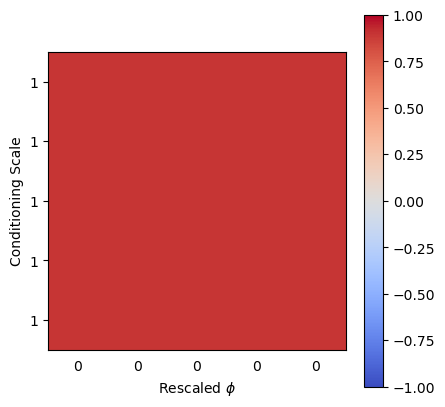

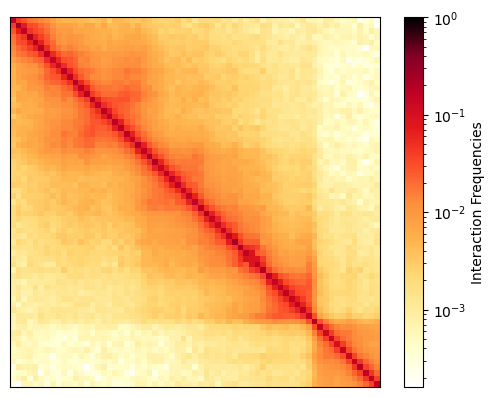

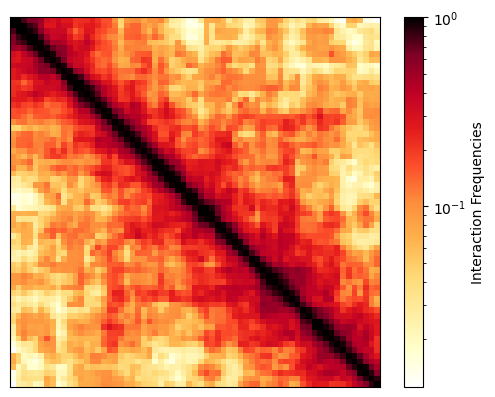

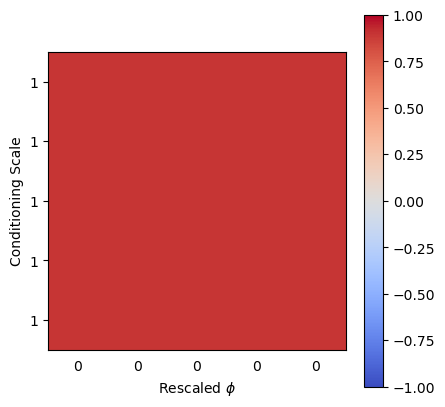

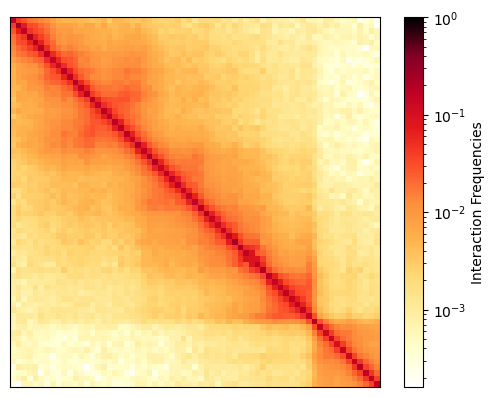

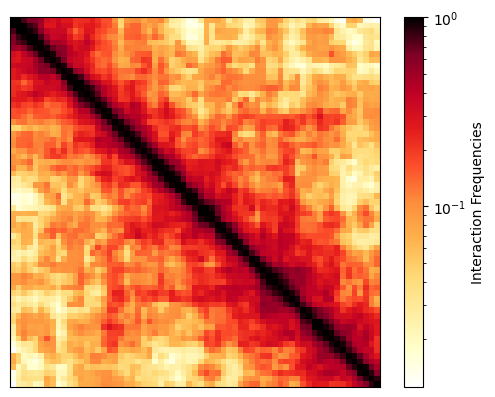

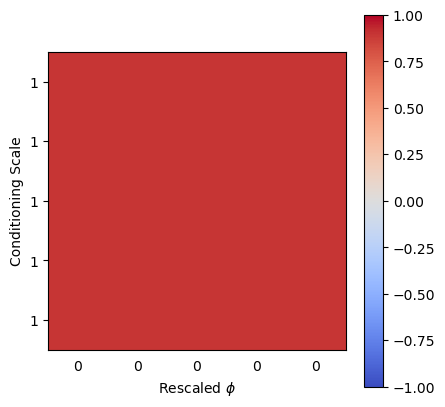

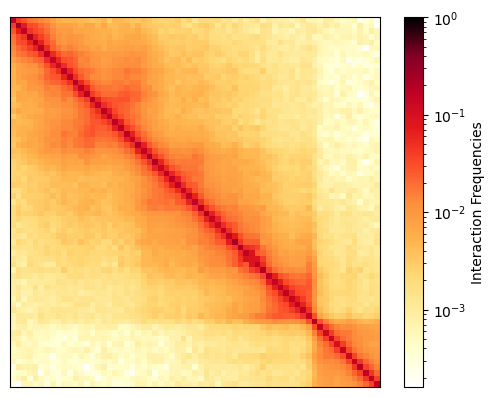

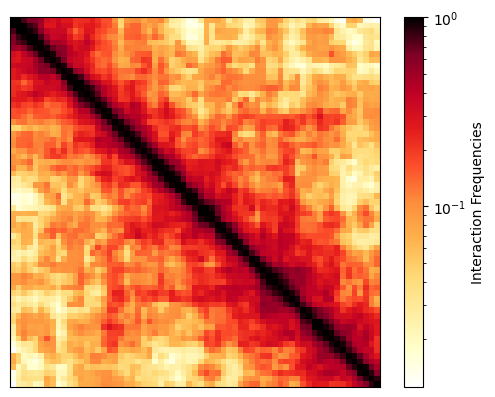

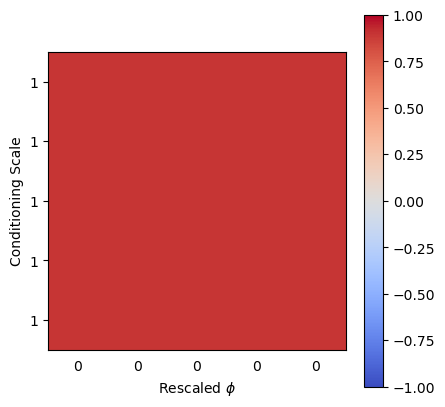

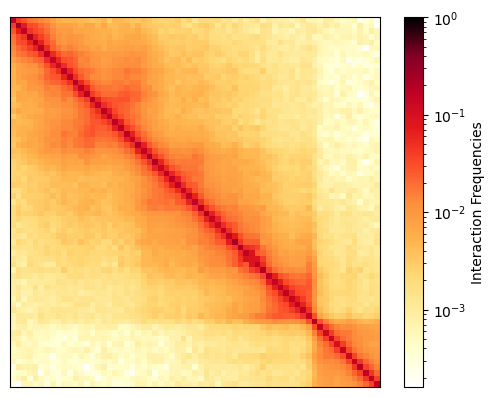

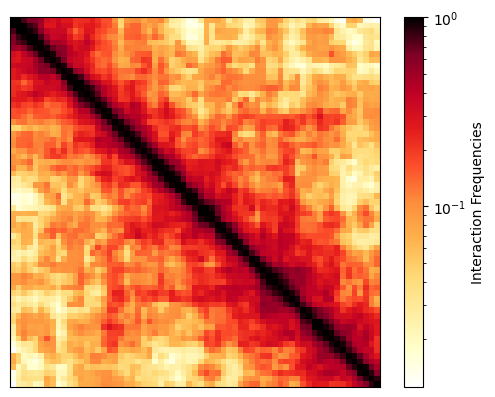

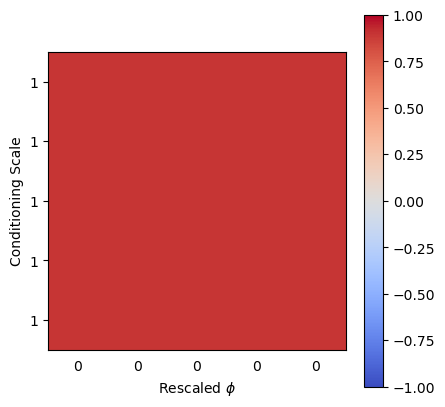

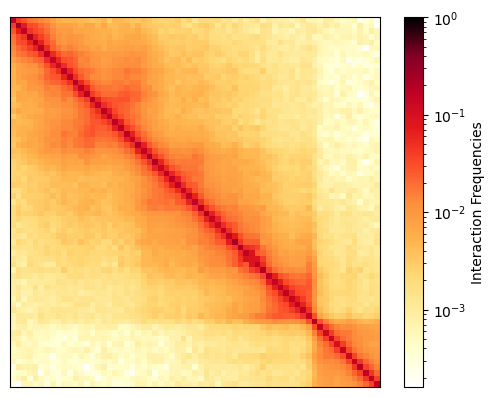

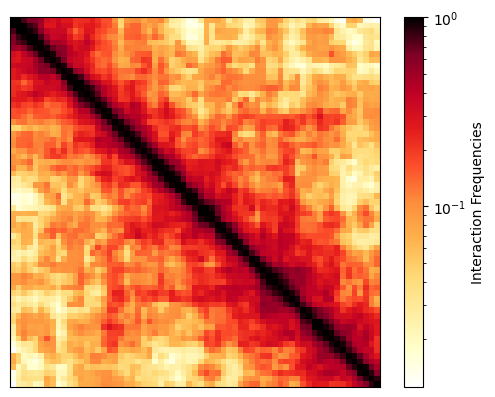

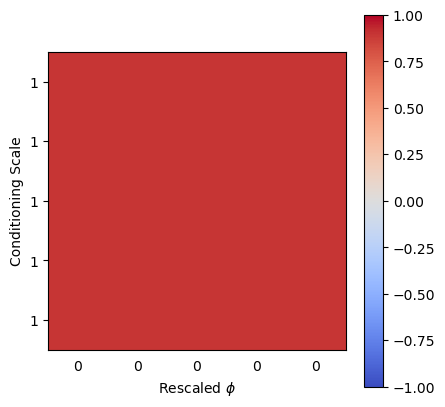

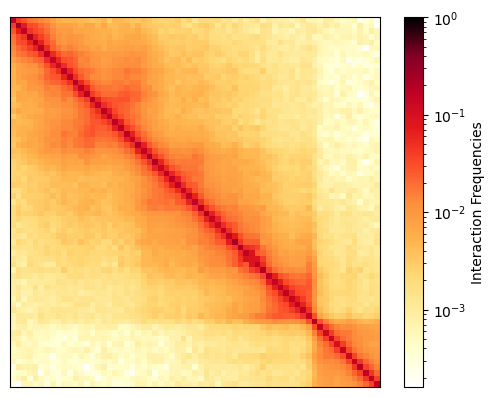

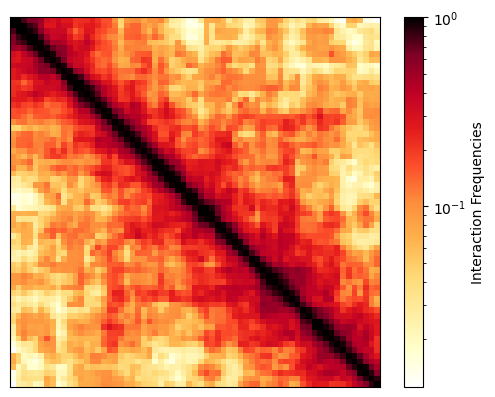

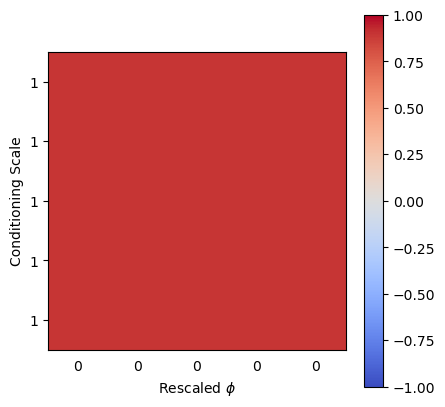

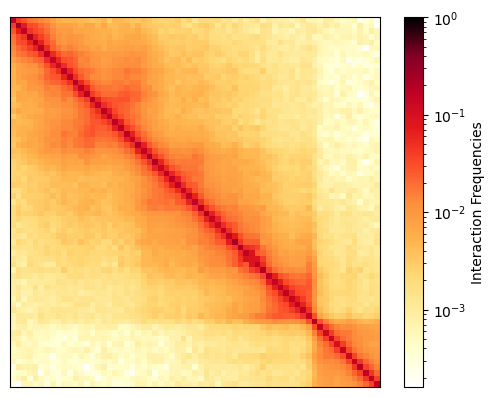

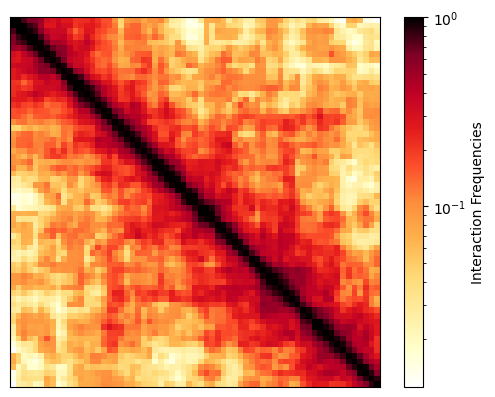

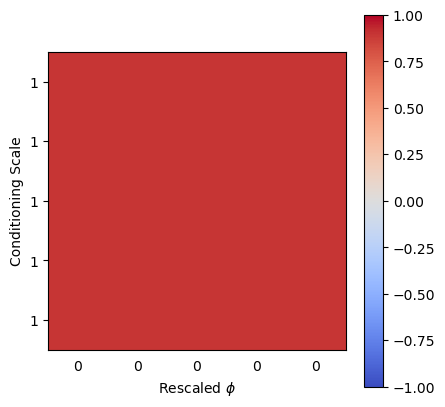

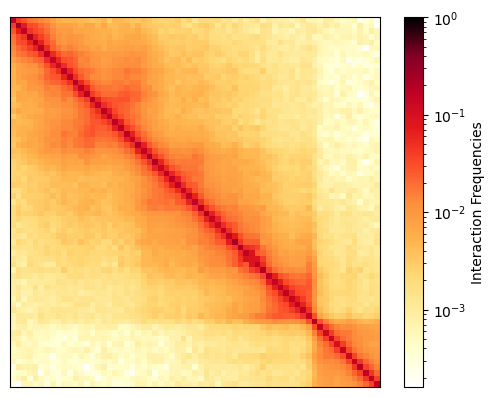

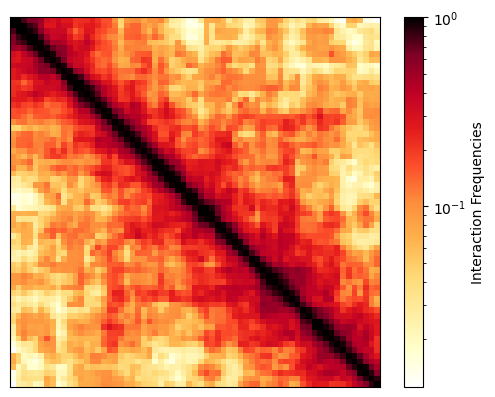

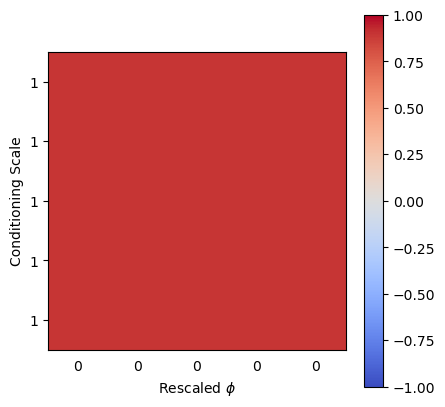

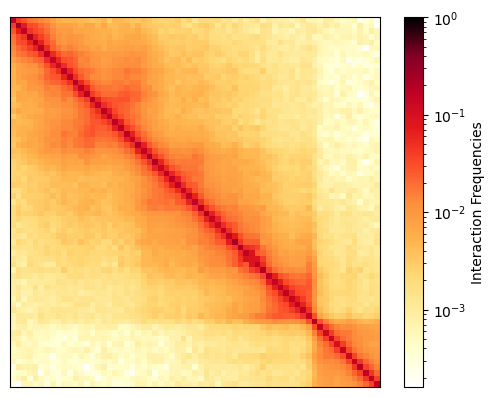

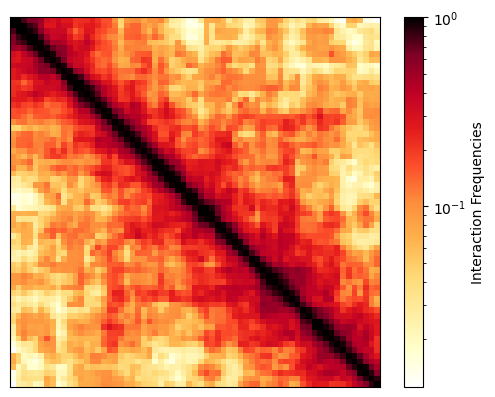

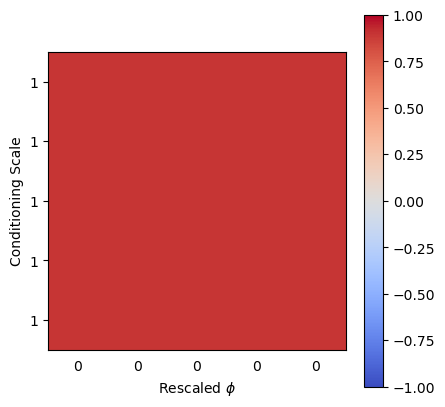

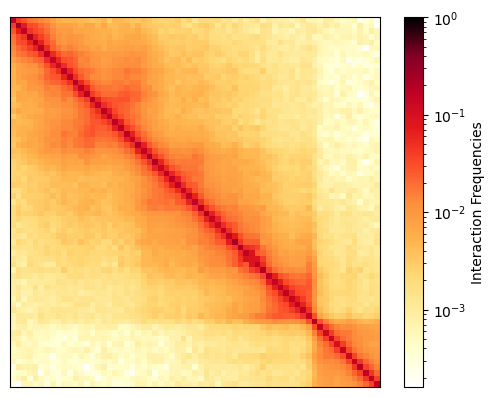

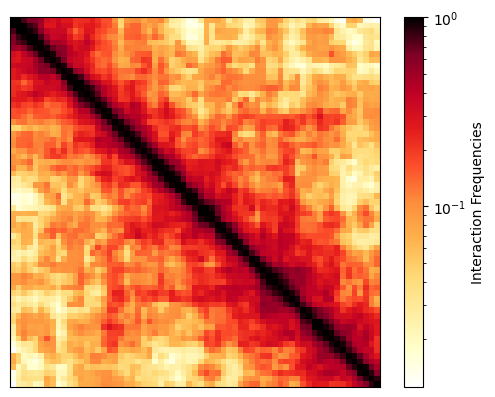

In [36]:
corrcoefs = {}
r_cs = {}
sigmas = {}
best_maps = {}
exp_maps = {}

for chrom in chroms:
    #print(f'CHROMOSOME {chrom}')
    corrcoefs[chrom] = {}
    r_cs[chrom] = {}
    sigmas[chrom] = {}
    best_maps[chrom] = {}
    exp_maps[chrom] = {}
    for region_idx in region_idxs:
        #print(f'REGION INDEX: {region_idx}')
        corrcoefs[chrom][region_idx] = {}
        r_cs[chrom][region_idx] = {}
        sigmas[chrom][region_idx] = {}
        best_maps[chrom][region_idx] = {}
        exp_maps[chrom][region_idx] = {}
        for cond_scale in cond_scales:
            #print(f'CONDITIONAL SCALE: {cond_scale}')
            corrcoefs[chrom][region_idx][cond_scale] = {}
            r_cs[chrom][region_idx][cond_scale] = {}
            sigmas[chrom][region_idx][cond_scale] = {}
            best_maps[chrom][region_idx][cond_scale] = {}
            exp_maps[chrom][region_idx][cond_scale] = {}

            for rescaled_phi in rescaled_phis:
                #print(f'RESCALED PHI: {rescaled_phi}')

                if not os.path.exists(f'{sample_dir}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'):
                    continue

                cc, rc, sig, bm, em = pipeline(
                    chrom,
                    region_idx,
                    sample_dir,
                    milestone,
                    [cond_scale],
                    [rescaled_phi],
                    exp_hic,
                    embeddings_idx[chrom]
                )
                '''
                try: 
                    cc, rc, sig, bm, em = pipeline(
                        chrom,
                        region_idx,
                        sample_dir,
                        milestone,
                        [cond_scale],
                        [rescaled_phi],
                        exp_hic,
                        embeddings_idx[chrom]
                    )
                except:
                    continue
                '''
                
                corrcoefs[chrom][region_idx][cond_scale][rescaled_phi] = cc
                r_cs[chrom][region_idx][cond_scale][rescaled_phi] = rc
                sigmas[chrom][region_idx][cond_scale][rescaled_phi] = sig
                best_maps[chrom][region_idx][cond_scale][rescaled_phi] = bm
                exp_maps[chrom][region_idx][cond_scale][rescaled_phi] = em

                

In [37]:
corrcoefs

{1: {0: {1: {0: tensor([[0.8980]], dtype=torch.float64)},
   2: {0: tensor([[0.8980]], dtype=torch.float64),
    0.25: tensor([[0.8980]], dtype=torch.float64),
    0.5: tensor([[0.8980]], dtype=torch.float64),
    0.75: tensor([[0.8980]], dtype=torch.float64)},
   4: {0: tensor([[0.8980]], dtype=torch.float64),
    0.25: tensor([[0.8980]], dtype=torch.float64),
    0.5: tensor([[0.8980]], dtype=torch.float64),
    0.75: tensor([[0.8980]], dtype=torch.float64),
    1: tensor([[0.8980]], dtype=torch.float64)},
   6: {},
   8: {}},
  50: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  100: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  150: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  200: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  250: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  300: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  350: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  400: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  450: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  500: {1: {}, 2: {}, 4: {}, 6: {}, 8: {}},
  550: {1: {}, 2: {}, 4: {

In [9]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.batch.clone()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

In [10]:
def get_best_rc_sigma2(
    gen_sample,
    exp_probs,
    r_cs = torch.arange(1.5,2.5,.05).tolist(),
    sigmas = torch.arange(2,6,.25).tolist()
):
    
    best_pcc = -2
    best_r_c = 0 
    best_sigma = 0 
    best_map = None
    for r_c in r_cs: 
        for sigma in sigmas: 
            #gen_probs = gen_sample.contact_probabilities(r_c=r_c,sigma=sigma)
            gen_probs = tanh_map(sample,r_c,sigma)
            pcc = gen_probs.pcc(exp_probs) 
            if pcc > best_pcc: 
                best_map = gen_probs
                best_r_c = r_c 
                best_sigma = sigma
                best_pcc = pcc
    
    return best_map,r_c,sigma,best_pcc

In [28]:
sample1.seg_len

64

In [32]:
hic_map.shape

torch.Size([65, 65])

torch.Size([500, 1, 32, 32])
torch.Size([500, 1, 64, 64])


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f293859ca60>)

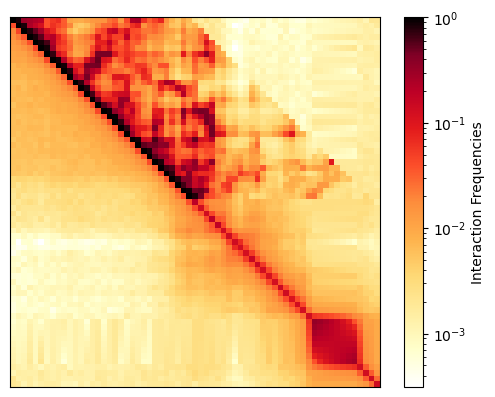

In [41]:
chrom_ = 1
milestone_ = 120 
region_idx_ = 100
cond_scale_ = 1.
rescaled_phi_ = 0 
#sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32_larger_embedder/'
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32/'

r_c = 1.5
sigma=3.5

sample1 = load_sample(
    sample_dir_,
    region_idx_,
    cond_scale_,
    rescaled_phi_,
    milestone_,
    chrom_
)

'''
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)
exp_map.plot()

hic_map = tanh_map(sample1,r_c,sigma)
hic_map.plot()

hic_map[]
'''

hic_map = tanh_map(sample1,r_c,sigma)
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)
#i,j = torch.triu_indices(hic_map.shape[-1],hic_map.shape[-1],1)
#hic_map.prob_map[j,i] = exp_map.prob_map[i,j]
#hic_map.plot()
i,j = compute_subregion.index_for_large_matrix
exp_map.prob_map[i,j] = hic_map.prob_map[i,j]
exp_map.plot()


In [ ]:
sample1 = load_sample(
    sample_dir,
    0,#region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    0,#region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

In [28]:
milestone = 120 


sample1 = load_sample(
    sample_dir,
    0,#region_idx,
    1.,#cond_scale,
    0.,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    0,#region_idx,
    1.,#cond_scale,
    0.,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)


r_c = 1.5
sigma = 2
region_idx = 0 
for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()
    
    '''
    
    gen_map = tanh_map(sample,r_c,sigma)
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)

    print(f'Chrom {chrom}: PCC = {gen_map.pcc(exp_map)}')
    gen_map.plot()
    exp_map.plot()
    '''

FileNotFoundError: [Errno 2] No such file or directory: '../../data/samples/small_model_large_embedder/sample_0_1_0_120_1.pkl'

Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.7206728582025635
Chrom X with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.7674744948632061


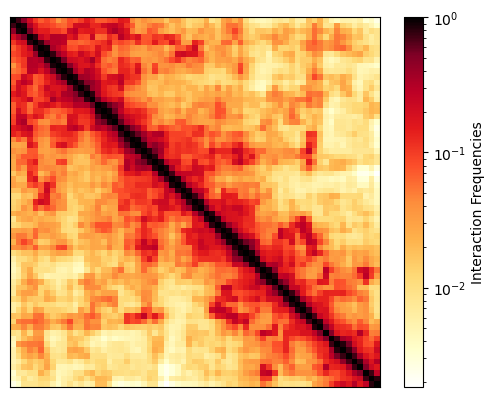

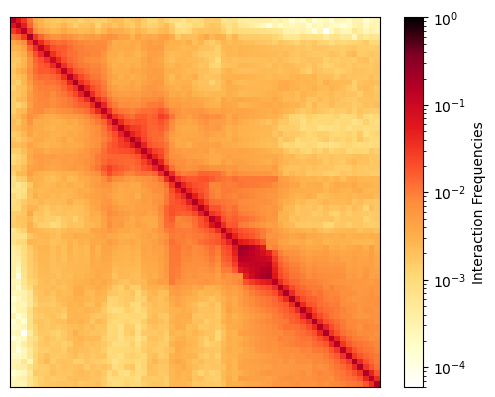

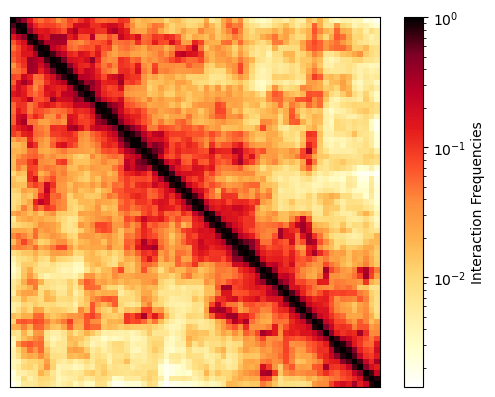

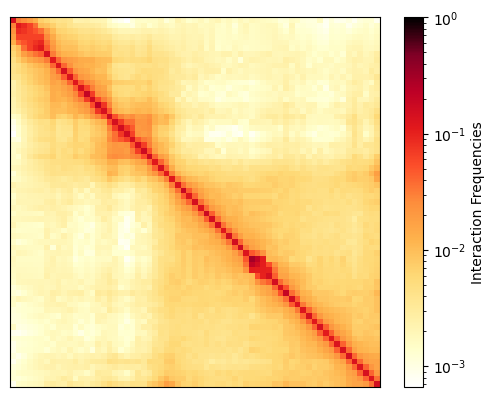

In [73]:
region_idx = 50 

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.4978477935485454
Chrom X with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.906211918122726


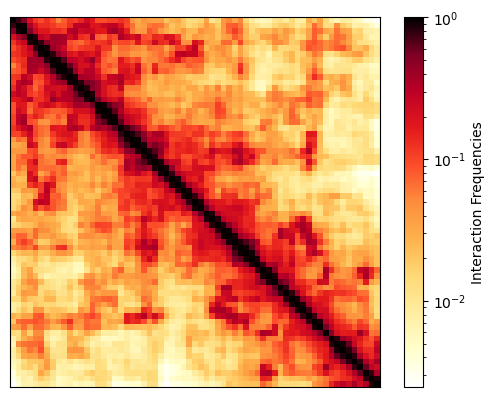

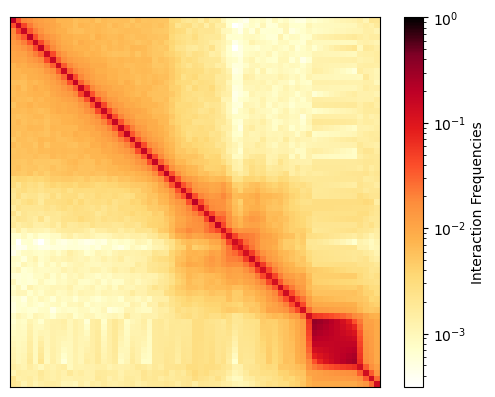

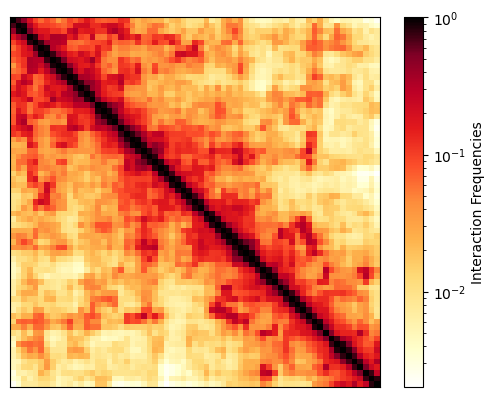

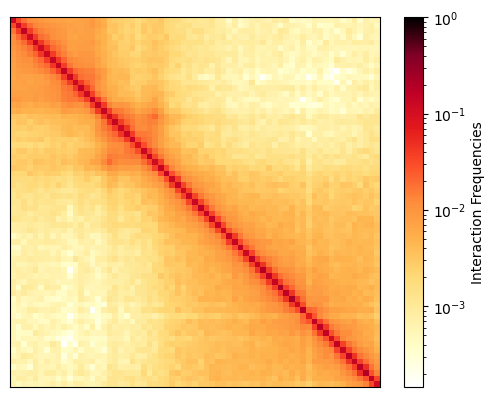

In [75]:
region_idx = 100

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.5243424432040965
Chrom X with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.7814377224623084


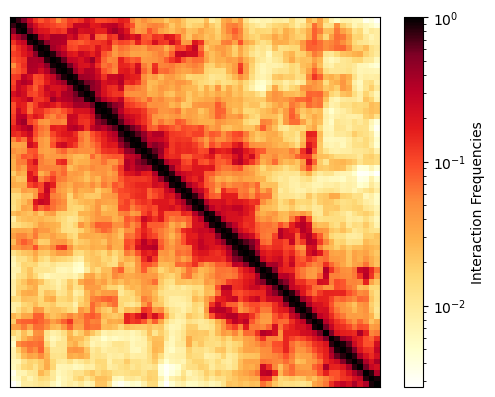

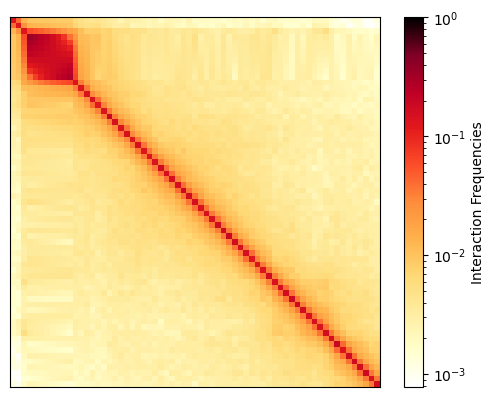

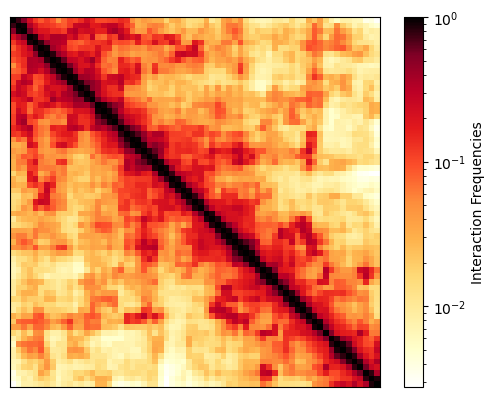

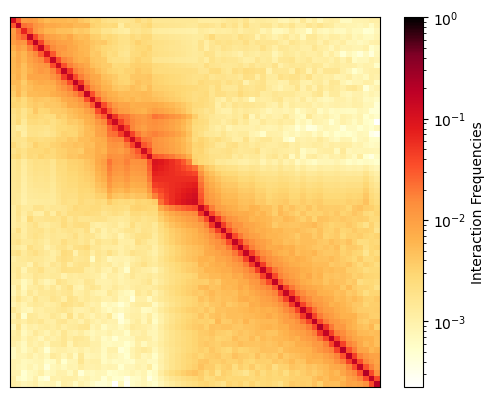

In [76]:
region_idx = 150

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.9328616124692788
Chrom X with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.930068331150058


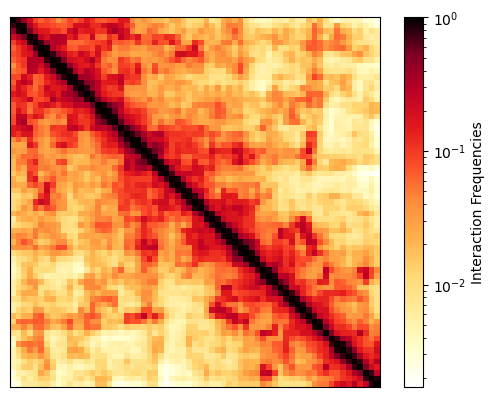

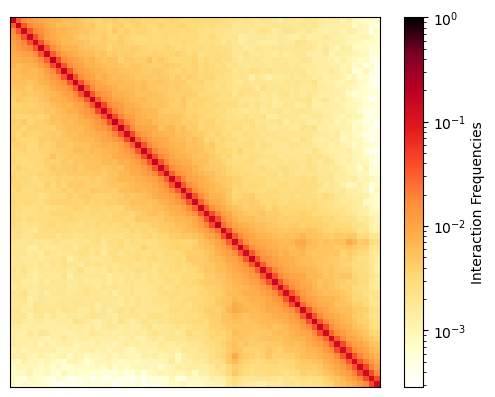

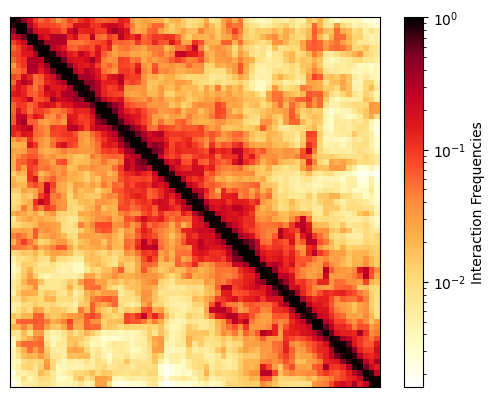

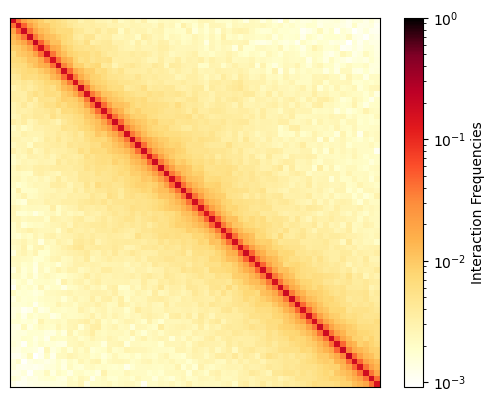

In [77]:
region_idx = 200

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


In [113]:
region_idx = 250

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


FileNotFoundError: [Errno 2] No such file or directory: '../diffusion_v1/sampling_small/sample_250_1_5_120_1.pkl'

In [ ]:
region_idx = 300

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    1#chrom,
)

sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)

for chrom,sample in [(1,sample1),('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.6761771719547253


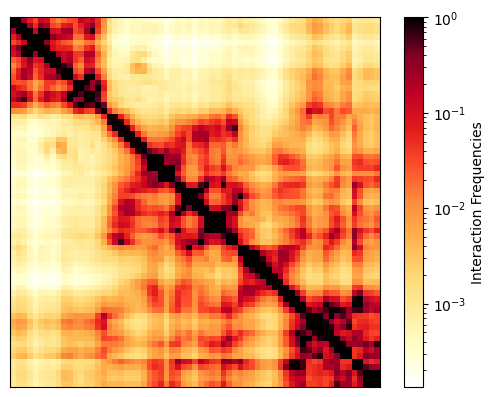

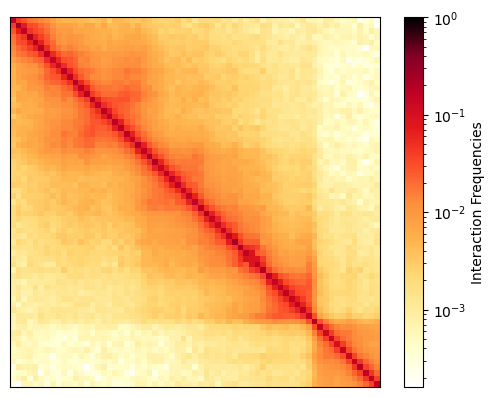

In [143]:
region_idx = 0 
chrom = 1
sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    65,#120,#milestone,
    chrom,#1#chrom,
)

'''
sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)
'''
for chrom,sample in [(1,sample1)]:#,('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2, $\sigma$ 4: PCC = 0.7342327427390827


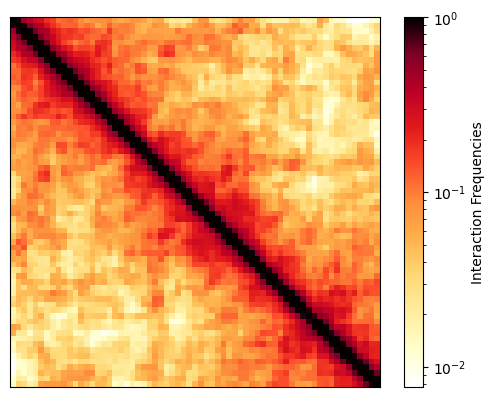

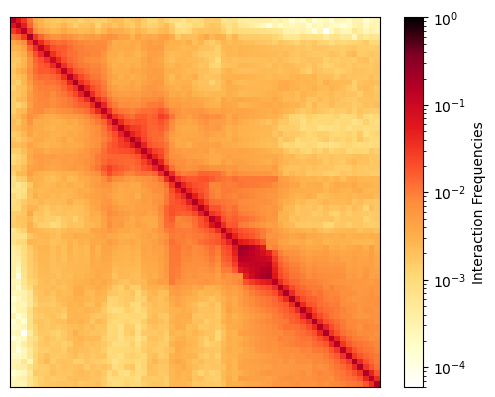

In [146]:
region_idx = 50
chrom = 1
sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    65,#120,#milestone,
    chrom,#1#chrom,
)

'''
sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)
'''
for chrom,sample in [(1,sample1)]:#,('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = [2],#torch.arange(1.5,2.5,.05).tolist(),
        sigmas = [4],#torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.6773075907065075


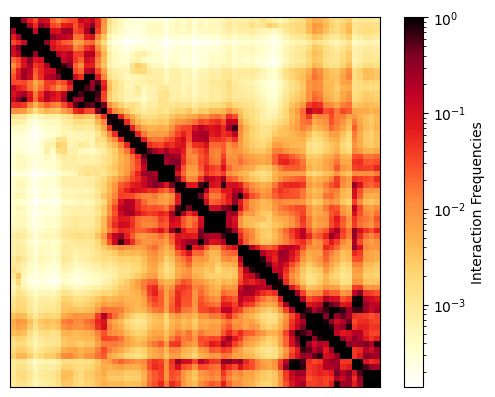

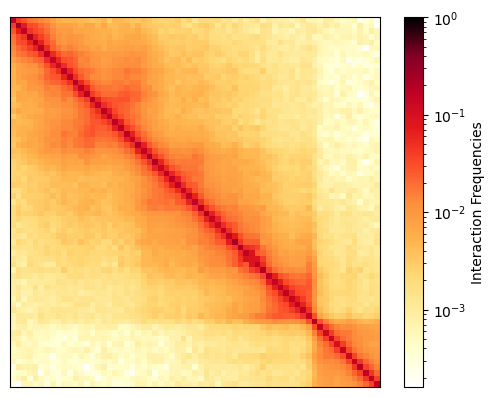

In [114]:
region_idx = 0

sample1 = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    69,#120,#milestone,
    1,#1#chrom,
)

'''
sampleX = load_sample(
    sample_dir,
    region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    120,#milestone,
    'X'#chrom,
)
'''
for chrom,sample in [(1,sample1)]:#,('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()


In [34]:
gen_map[:]

tensor([[1.0000, 0.8817, 0.8817,  ..., 0.8817, 0.8817, 0.8817],
        [0.8817, 1.0000, 0.8817,  ..., 0.8817, 0.8817, 0.8817],
        [0.8817, 0.8817, 1.0000,  ..., 0.8817, 0.8817, 0.8817],
        ...,
        [0.8817, 0.8817, 0.8817,  ..., 1.0000, 0.8817, 0.8817],
        [0.8817, 0.8817, 0.8817,  ..., 0.8817, 1.0000, 0.8817],
        [0.8817, 0.8817, 0.8817,  ..., 0.8817, 0.8817, 1.0000]],
       dtype=torch.float64)

In [9]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
embeddings = pd.read_pickle(emb_fp(chrom))#.index 
embedding_idx = embeddings.index

In [ ]:
corrcoefs, r_cs, sigmas = pipeline(
    chrom,
    region_idx,
    sample_dir,
    milestone,
    cond_scales,
    rescaled_phis,
    exp_hic=None,
    embedding_idx=embedding_idx
)

In [ ]:
device = 'cuda'
exp_hic = HiCDataset()
exp_probs = get_exp_map(region_idx,exp_hic,embeddings.index).to(device)
exp_probs.plot()

In [ ]:
plt.hist(r_cs.cpu().numpy().flatten())

In [ ]:
plt.hist(sigmas.cpu().numpy().flatten())

In [ ]:
plt.hist(corrcoefs.flatten().cpu().numpy())

In [ ]:
asdf

In [ ]:
# From the old large model
r_c = 1.75
sigma = 4
gen_probs = load_sample(
    directory='../../data/samples/large_model/',
    region_idx=0,
    cond_scale=1,
    rescaled_phi=.2,
    milestone=96,
    chrom=1
)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [ ]:
r_c = 2
sigma = 4
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [ ]:
chrom='X'
cond_scale=1.
rescaled_phi=0.5
r_c=1.75
sigma=3

In [ ]:
chrom = 1
region_idx = 0 
gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [ ]:
cond_scale=5.
rescaled_phi=0.5
r_c=1.75
sigma=3

sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom=1)
sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom='X')

sample_1.cuda()
sample_2.cuda()

p1 = sample_1.contact_probabilities()
p2 = sample_2.contact_probabilities()

p1.pcc(p2) 

In [ ]:
sample_1.batch

In [ ]:
def hic_via_tanh(sample,r_c,sigma):

    sample.unnormalize_()
    r = sample.batch.clone()
    '''
    #r = self.batch.clone() # Distances
    if self.coords is None: 
        self.get_coords()

    r = torch.cdist(self.coords,self.coords)
    '''
    
    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )

    mask^= True 
    r[mask] = .5 * ( r_c / r[mask] )**4

    return r.mean(0).squeeze().float()#.to(self.batch_dtype) 

In [ ]:
from HiCMap import pcc

sample_dir = '../diffusion_v1/sampling_small/'#'../../data/samples/small_model/'

cond_scale=1.
rescaled_phi=1.
r_c=1.75
sigma=3

#sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom=1)
#sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom='X')
sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone=38,chrom='X')
sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone=69,chrom=1)

sample_1.cuda()
sample_2.cuda()

p1 = hic_via_tanh(sample_1,r_c,sigma)
p2 = hic_via_tanh(sample_2,r_c,sigma)
#p1 = sample_1.contact_probabilities()
#p2 = sample_2.contact_probabilities()

#p1.pcc(p2) 
pcc(p1,p2) 

In [ ]:
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap
def plot_hic(
    mat,
    vmin=None,
    vmax=1,
    cmap='fall'
):

    norm = LogNorm(vmin=vmin,vmax=vmax)
    #n,hic_map = self.nbins, self.prob_map
    hic_map = mat.squeeze()
    n = hic_map.shape[0] 
    extent = (0,n,n,0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    im = ax.matshow(
        hic_map.cpu().numpy(),
        norm=norm,
        cmap=cmap,
        extent=extent
    );
    ax.xaxis.set_visible(False) # don't show the arbitrary ticks
    ax.yaxis.set_visible(False) # don't show the arbitrary ticks 
    
    cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

    return fig,ax,im,cbar

In [ ]:
plot_hic(p1)
plot_hic(p2)

In [ ]:
entry = 0 
for s in [sample_1,sample_2]: 
    plt.matshow(
        s.batch[entry,...].squeeze().cpu().numpy()
    )
    

In [ ]:
chrom = 1
region_idx = 50
gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [ ]:
a = pd.read_pickle('../../data/embeddings/chrom_1.tar.gz')
b = pd.read_pickle('../../data/embeddings/chrom_X.tar.gz') 

In [ ]:
print(len(a))

In [ ]:
print(len(b))

In [ ]:
def get_best_rc_sigma(
    gen_sample,
    exp_probs,
    r_cs = torch.arange(1.5,2.5,.05).tolist(),
    sigmas = torch.arange(2,6,.25).tolist()
):
    
    best_pcc = -2
    best_r_c = 0 
    best_sigma = 0 
    best_map = None
    for r_c in r_cs: 
        for sigma in sigmas: 
            gen_probs = gen_sample.contact_probabilities(r_c=r_c,sigma=sigma)
            pcc = gen_probs.pcc(exp_probs) 
            if pcc > best_pcc: 
                best_map = gen_probs
                best_r_c = r_c 
                best_sigma = sigma
                best_pcc = pcc
    
    return best_map,r_c,sigma,best_pcc

In [135]:
region_idx=50
chrom='X'
sample = load_sample(
    sample_dir,
    0,#region_idx,
    1.,#cond_scale,
    .5,#rescaled_phi,
    38,#milestone,
    chrom,
)

In [136]:
exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)

In [137]:
gen_map,r_c,sigma,best_pcc = get_best_rc_sigma2(sample,exp_map)

Chrom X with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.8341135362819774


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f6670413430>)

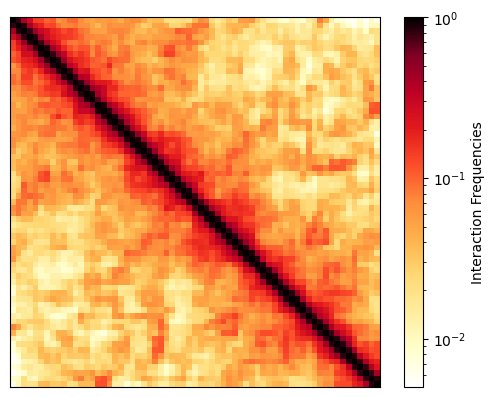

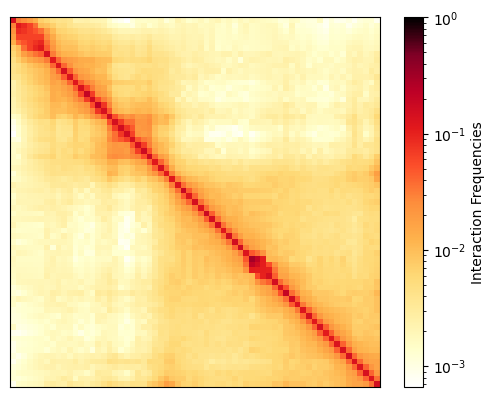

In [138]:
print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
gen_map.plot()
exp_map.plot()

Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.8980142742384565


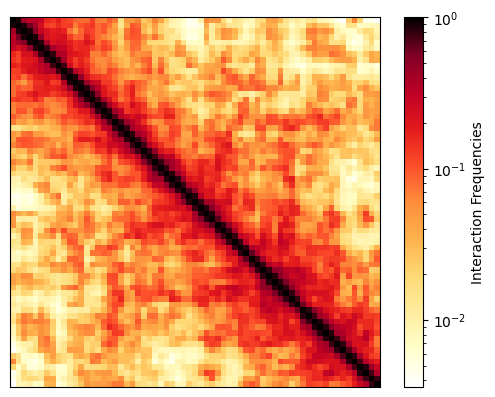

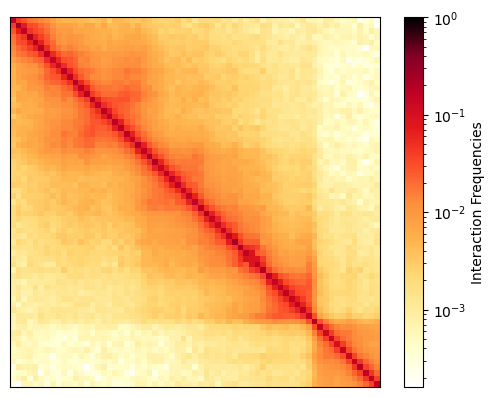

In [32]:
milestone_ = 84 
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/small_model_large_embedder/'

sample1 = load_sample(
    sample_dir_,
    0,#region_idx,
    1.,#cond_scale,
    0.,#rescaled_phi,
    milestone_,
    1#chrom,
)

r_c = 1.5
sigma = 2
region_idx = 0 
for chrom,sample in [(1,sample1)]:#,('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()
    
    '''
    
    gen_map = tanh_map(sample,r_c,sigma)
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)

    print(f'Chrom {chrom}: PCC = {gen_map.pcc(exp_map)}')
    gen_map.plot()
    exp_map.plot()
    '''

In [33]:
gen_map1 = gen_map.clone()

Chrom 1 with $r_c$ 2.450000047683716, $\sigma$ 5.75: PCC = 0.9101987858000173


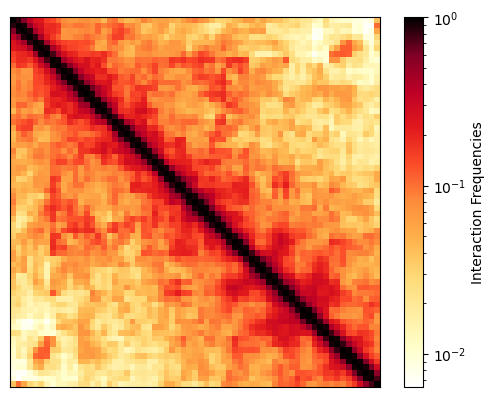

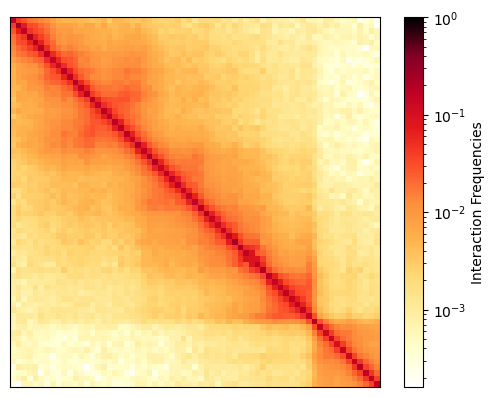

In [34]:
milestone_ = 120
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/small_model/'

sample1 = load_sample(
    sample_dir_,
    0,#region_idx,
    1.,#cond_scale,
    0.,#rescaled_phi,
    milestone_,
    1#chrom,
)

r_c = 1.5
sigma = 2
region_idx = 0 
for chrom,sample in [(1,sample1)]:#,('X',sampleX)]:
    
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)
    gen_map,r_c,sigma,best_pcc = get_best_rc_sigma(
        sample,
        exp_map,
        r_cs = torch.arange(1.5,2.5,.05).tolist(),
        sigmas = torch.arange(2,6,.25).tolist()
    )

    print(f'Chrom {chrom} with $r_c$ {r_c}, $\\sigma$ {sigma}: PCC = {best_pcc}')
    gen_map.plot()
    exp_map.plot()
    
    '''
    
    gen_map = tanh_map(sample,r_c,sigma)
    exp_map = get_exp_map(region_idx,exp_hic,embeddings_idx[chrom],interp_nans=True)

    print(f'Chrom {chrom}: PCC = {gen_map.pcc(exp_map)}')
    gen_map.plot()
    exp_map.plot()
    '''